# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set(font_scale = 1.2)
%matplotlib inline

# Load paths and data

In [4]:
# load et data and models
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'
models_path  = './results/WK/frame_models/'
models_path_scenes  = './results/WK/scene_models/'

# All saliency models
df = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_diary.csv'))
df.columns 

Index(['ID', 'FIX_idx', 'NSS_vn', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
       'NSS_dg', 'NSS_sp', 'NSS_fg', 'FRAME_idx'],
      dtype='object')

# Fixed effects - Frames

Plot fixed effects for each frame

In [5]:
def create_coefficients_table(models_path=models_path, coef_name=['ADHDCategoryADHD-C']):
    """
    coef_name (list(str)) values: Age, Sex1, IQ, EHQ_TotalAmbidextrous, EHQ_TotalLefthanded, samplingRate120,
                            ADHDCategoryADHD-C, ADHDCategoryADHD-IN, SemLevel1, ADHDCategoryADHD-C:SemLevel1,
                            ADHDCategoryADHD-IN:SemLevel1
    """
    frame_coefs = []
    for file in os.listdir(models_path):
        if file.endswith('.csv'):
            fr_number = [int(file.split('_')[-1].rstrip('.csv'))]
            
            try:
                df_aux = pd.read_csv(os.path.join(models_path,file)).set_index('Unnamed: 0')
                frame_coefs.append(fr_number +
                                    df_aux.loc[coef_name, ['t value', 'Pr(>|t|)']].values.tolist()[0])
            except:
                print(f'Error in {file}')
                frame_coefs.append(fr_number + [0,0])
                
    columns_names = ['Frame'] + [f'{coef}_coef' for coef in coef_name] + [f'{coef}_pval' for coef in coef_name]
    return pd.DataFrame(frame_coefs,columns=columns_names).sort_values(by='Frame').reset_index(drop=True)
    
def plot_coefficients_frames(models_path, coef_name, is_scenes = False):
    
    df_aux = create_coefficients_table(models_path=models_path, coef_name=coef_name)
    
    _, ax = plt.subplots(2,2,figsize=(16,10),gridspec_kw={'width_ratios': [3, 1]})
    
    # tval for coef
    #tval = df_aux.loc[:,['Frame/Scene', coef_name[0]+'_coef']].rename({coef_name[0]+'_coef':'tval'})
    col_name = coef_name[0]+'_coef'
    col_frame = 'Frame'
    
    tval = df_aux[[col_frame, col_name]].copy()
    tval.plot(x=col_frame, y=col_name,kind='line',ax=ax[0,0], legend=True)
    ax[0,0].axhline(0, color='black',linestyle='--')
    ax[0,0].axhline(-1.9, color='black', linestyle='-.')
    #ax[0,0].axhline(-1.9, color='black', linestyle='-.')
    ax[0,0].set_ylabel('tval')
    if is_scenes: ax[0,0].set_xlabel('Scene')
    
    # plot tval distribution 
    tval[col_name].hist(ax=ax[0,1],orientation='horizontal')
    
    # TODO: use a bonferroni correction o any needed
    col_name = coef_name[0]+'_pval'
    pval = df_aux[[col_frame, col_name]].copy()
    pval[col_name] = pval[col_name].apply(np.log10)
    pval.plot(x=col_frame, y=col_name,kind='line',ax=ax[1,0], legend=True)
    ax[1,0].axhline(np.log10(0.05), color='r', linestyle='--')
    pval[col_name].hist(ax=ax[1,1],orientation='horizontal')
    ax[1,0].set_ylabel('log10(pval)')
    if is_scenes: ax[1,0].set_xlabel('Scene')
        
    plt.tight_layout()
    plt.show()
    return tval, pval

## Effects of variables

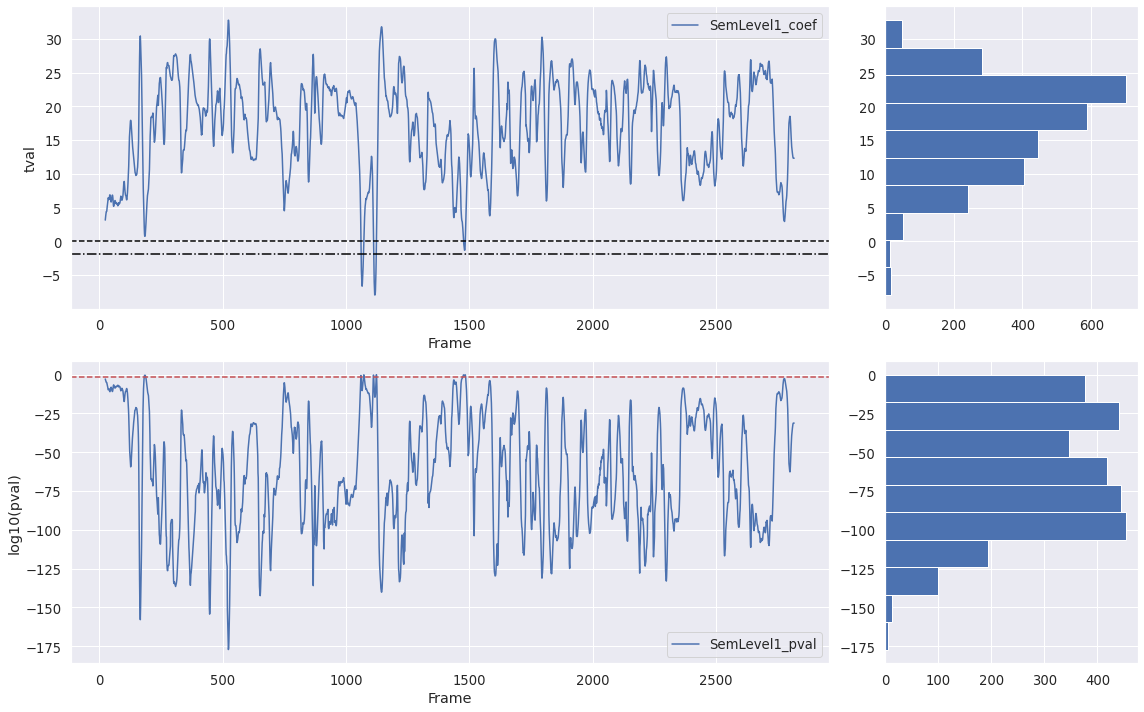

In [6]:
tval , pval = plot_coefficients_frames(models_path=models_path, coef_name=['SemLevel1'])

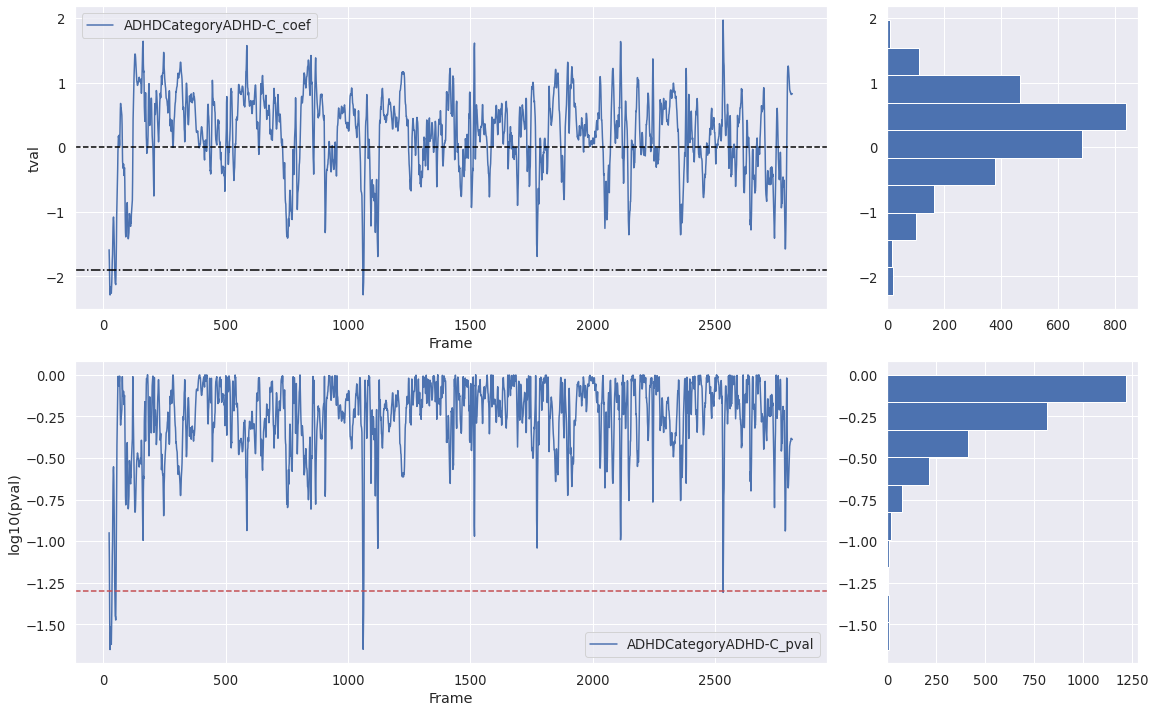

In [7]:
tval , pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-C'])

In [8]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,ADHDCategoryADHD-C_pval
1040,1064,-1.431588
4,28,-1.651480
1037,1061,-1.329868
9,33,-1.620493
10,34,-1.506097
2509,2533,-1.307398
27,51,-1.474095
2,26,-1.405688
26,50,-1.452253
6,30,-1.592136


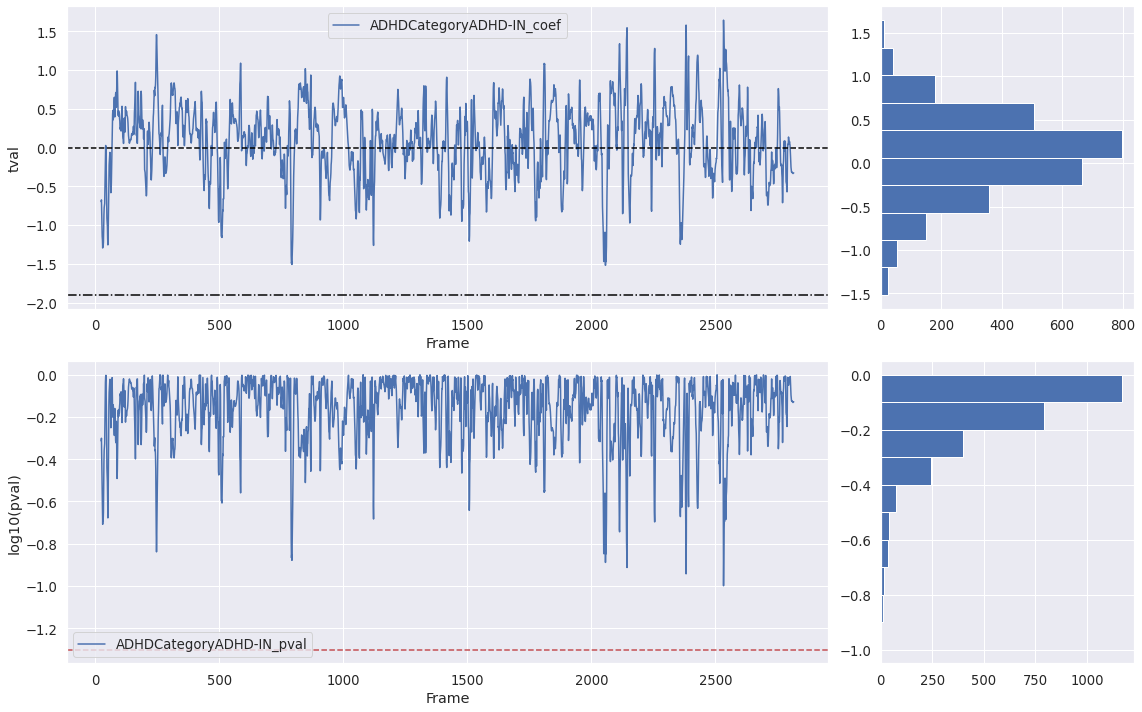

In [9]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-IN'])

In [10]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(0, 2)


## Effects of interaction

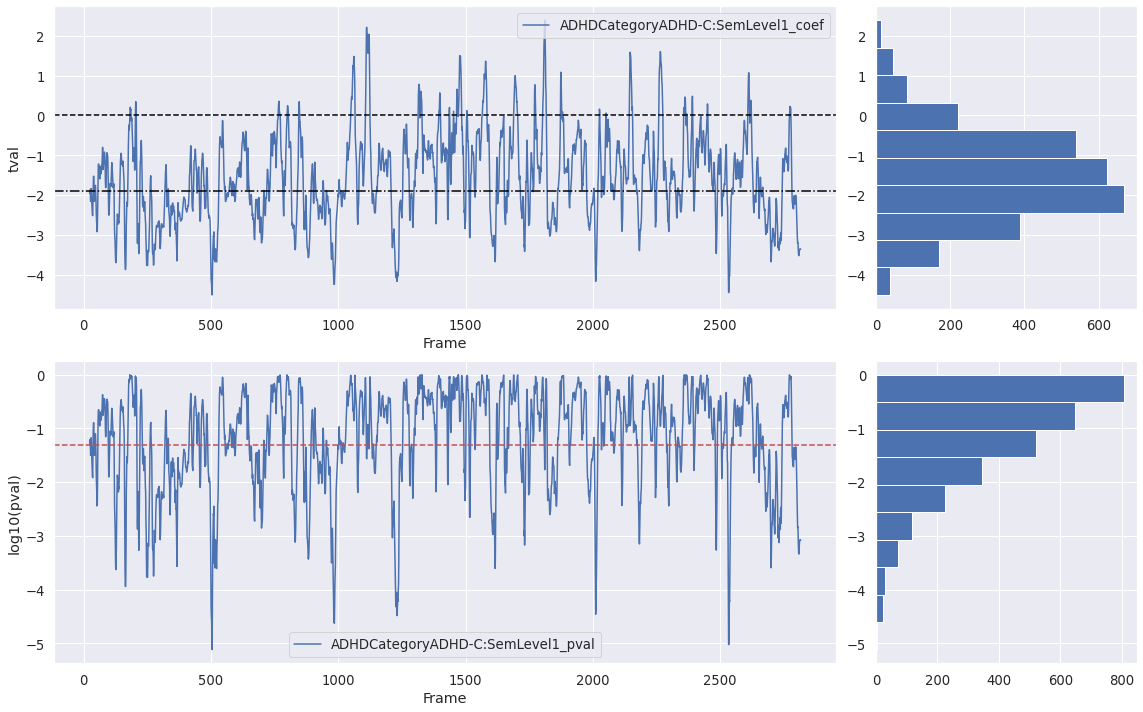

In [11]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-C:SemLevel1'])

In [12]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,ADHDCategoryADHD-C:SemLevel1_pval
2507,2531,-3.083137
2671,2695,-1.657446
2090,2114,-2.435330
97,121,-2.008915
1265,1289,-1.338195
1976,2000,-1.484380
660,684,-1.991325
144,168,-2.182190
1576,1600,-2.389037
2058,2082,-1.458886


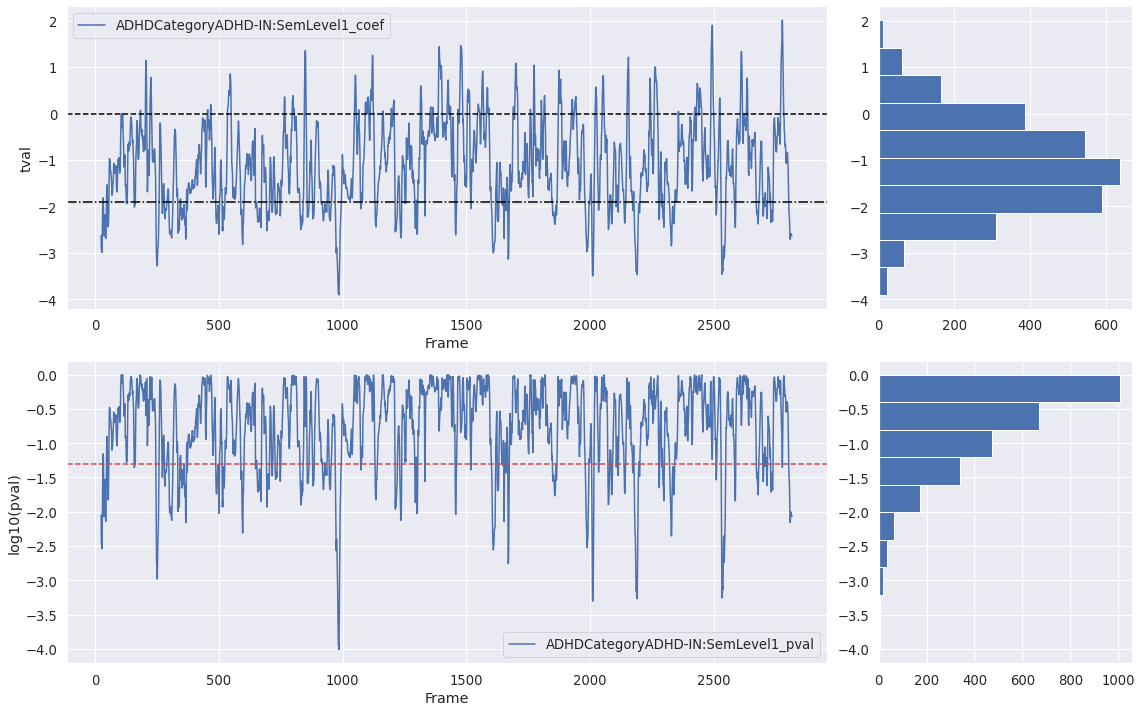

In [13]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-IN:SemLevel1'])

# Fixed effects - Scenes

In [6]:
#scenes_data =  pd.read_csv('../videos_data/Diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
scenes_data = pd.read_csv('/hdd/ReposPesados/SaliencyADHD/videos_data/Diary/scenes/ManualSceneCut_WK.csv', 
                          sep=';').rename(columns={'SceneNumber': 'Scene Number','StartFrame':'Start Frame', 'EndFrame':'End Frame'})

## Effects of variables

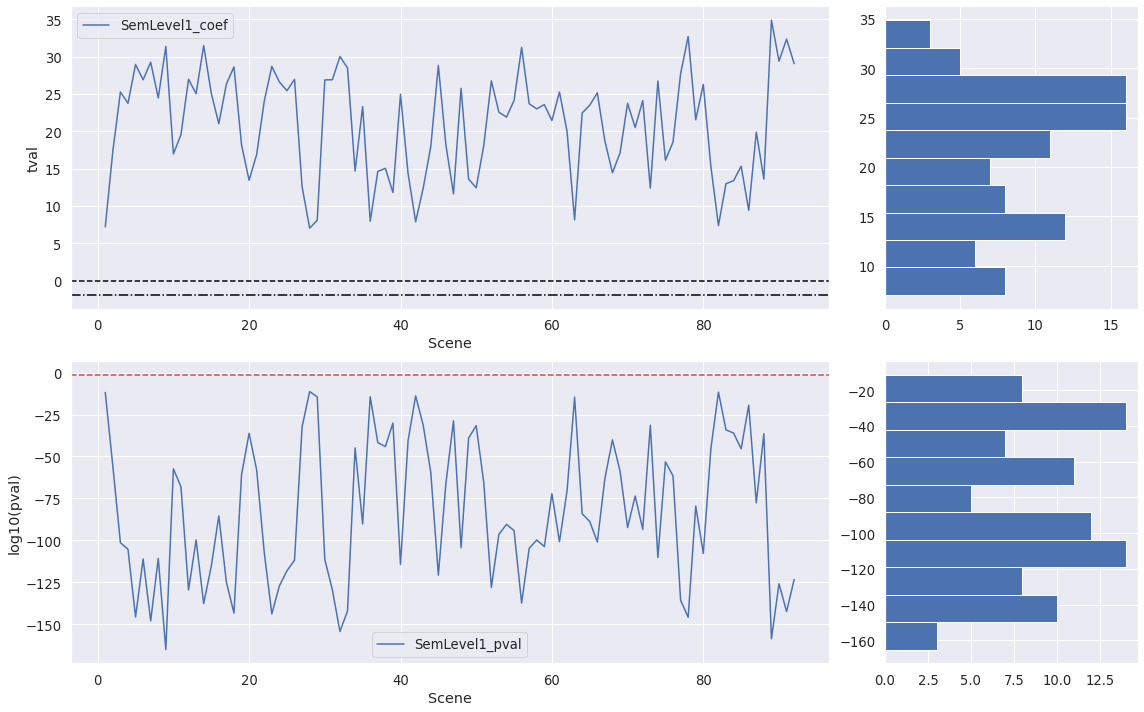

In [7]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['SemLevel1'], is_scenes=True)

In [8]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,SemLevel1_pval
5,6,-111.110934
8,9,-165.078703
76,77,-135.664615
75,76,-61.571910
73,74,-110.198752
71,72,-93.406634
50,51,-65.703521
91,92,-123.356558
18,19,-60.920705
52,53,-96.371812


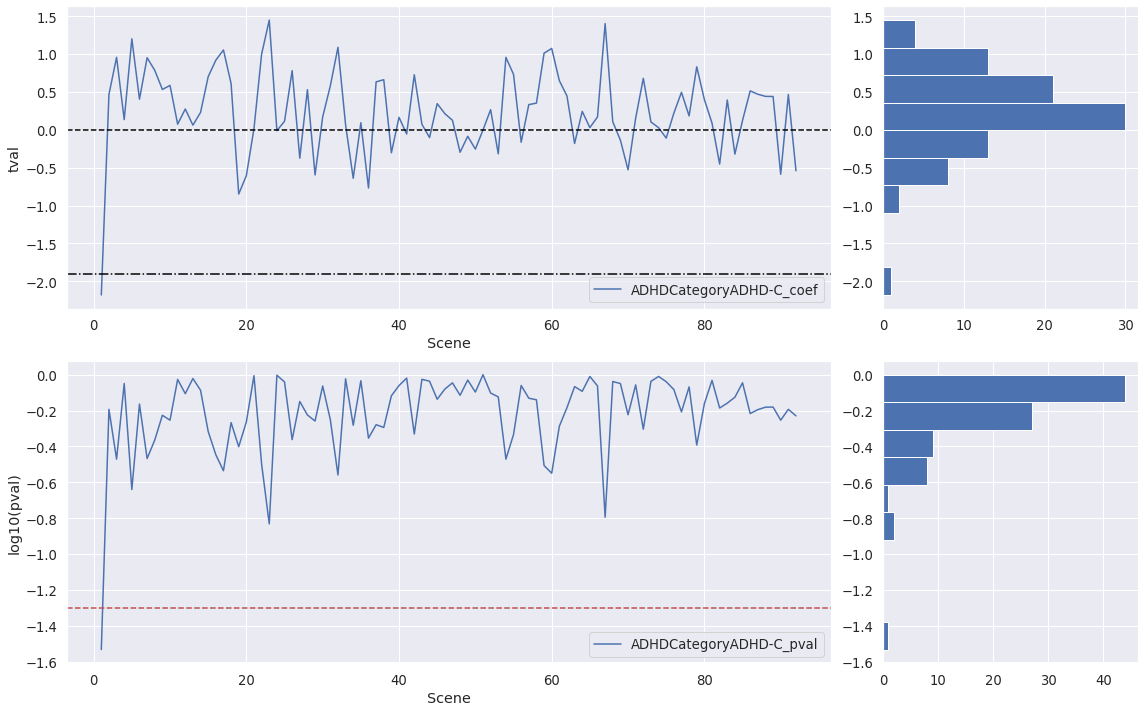

In [9]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-C'], is_scenes=True)

In [10]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(1, 2)


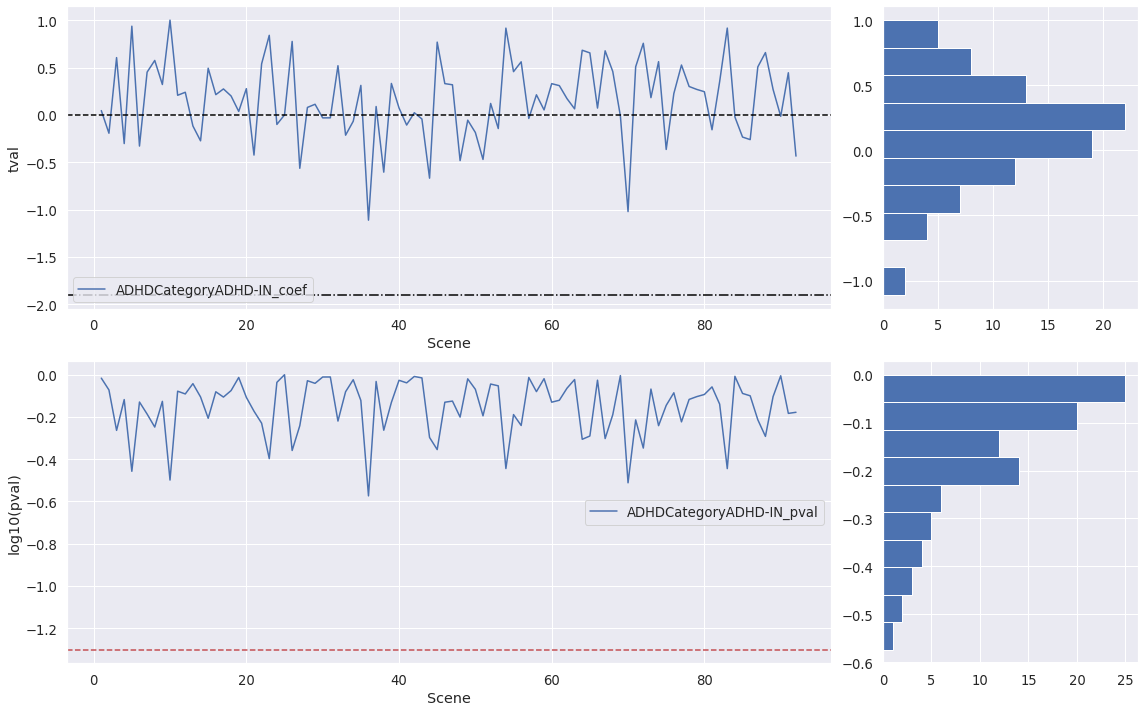

In [11]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-IN'], is_scenes=True)

In [12]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(0, 2)


## Effects of interaction

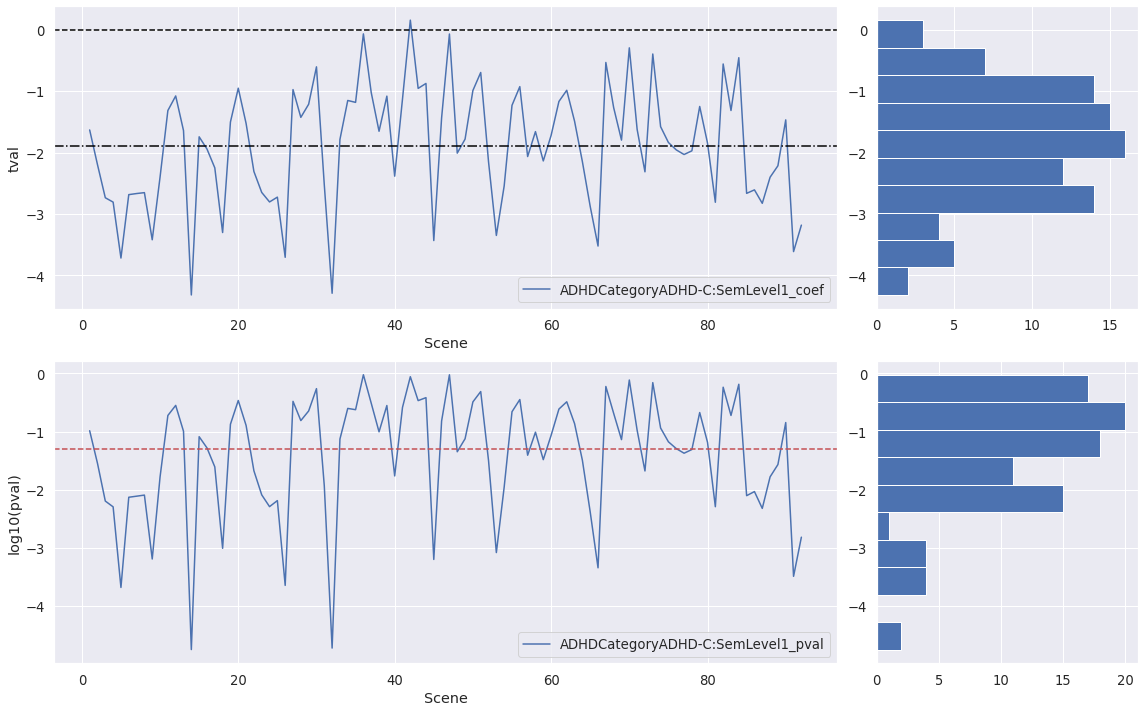

In [13]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-C:SemLevel1'], is_scenes=True)

In [14]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,ADHDCategoryADHD-C:SemLevel1_pval
21,22,-1.674062
24,25,-2.186083
91,92,-2.814626
65,66,-3.340970
87,88,-1.778426
7,8,-2.091531
80,81,-2.291366
47,48,-1.347018
64,65,-2.381678
13,14,-4.745450


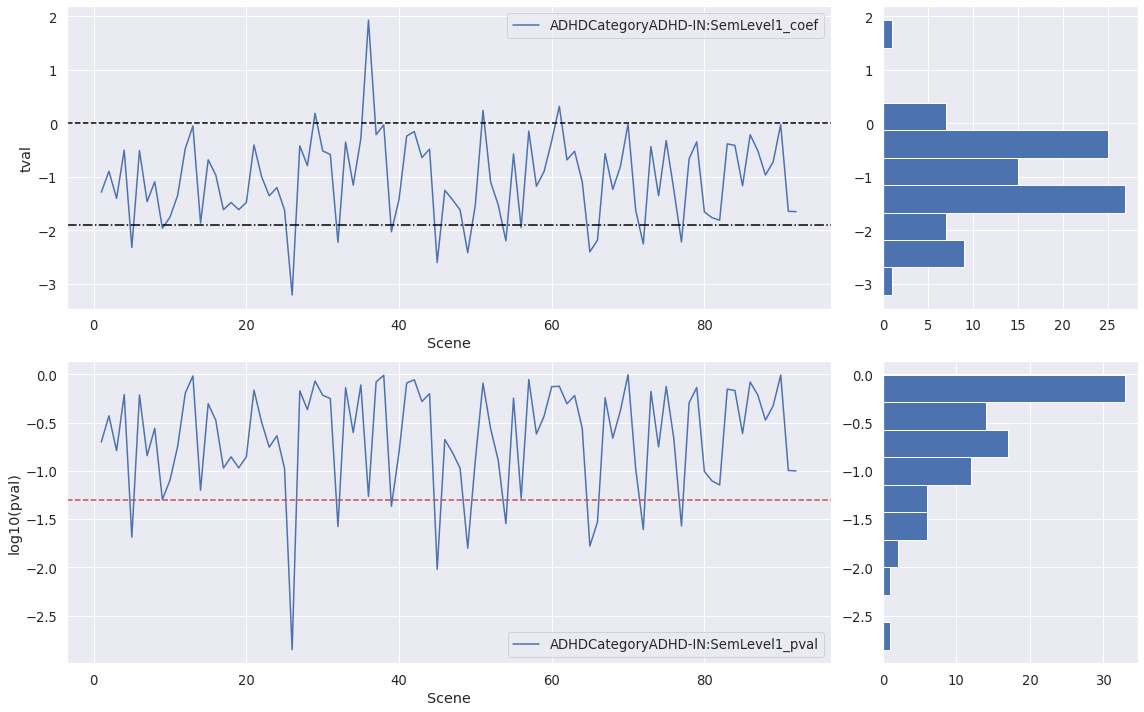

In [17]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-IN:SemLevel1'], is_scenes=True)

In [21]:
pval[pval.iloc[:,1] < np.log10(0.05)].sort_values(by='Frame')['Frame'].values
#.sample(10)

array([ 5, 26, 32, 39, 45, 49, 54, 65, 66, 72, 77])

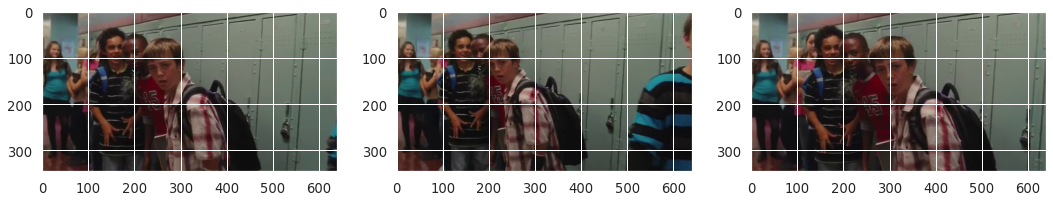

In [25]:
plot_sample_scenes(66, video_name='Diary', images_path='../videos_data/')